In [5]:
import numpy as np
import pandas as pd
import math
import copy
from random import seed
from random import random
import matplotlib.pyplot as plt  # import matplotlib for plotting and visualization
import matplotlib
import PIL
import PIL.Image
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from struct import unpack
import os
import shutil

In [6]:
## images path
orig_path = pathlib.Path(r'C:\Users\istra\img\images\images')
destin_path= pathlib.Path(r'C:\Users\istra\Google Drive\Cours HEC\Maitrise\Semestre 2\Machine_Learning\TP GROUPE\book_covers')
image_count=len(list(orig_path.glob('*.jpg')))
print(image_count)

53618


Opening the csv file

In [7]:
goodread = pd.read_csv(r'C:\Users\istra\img\book_data.csv')

Getting the number of tags per genre


In [91]:
nonfiction = pd.DataFrame(all_genres)[listna]

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [95]:

nonfiction_long =pd.DataFrame([genre for book in nonfiction for genre in book])

TypeError: 'int' object is not iterable

In [88]:
listna =goodread["genres"].str.contains('Nonfiction')
listna[listna.isna()] = False
goodread[listna]

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
79,Frank McCourt,Imbued on every page with Frank McCourt's asto...,NaN,Paperback,9.78001E+12,452 pages,4.09,466398,10595,Angela's Ashes,Nonfiction|Autobiography|Memoir|Biography,https://images.gr-assets.com/books/1348317139l...
117,Mitch Albom|Saulius Dagys,"Maybe it was a grandparent, or a teacher or a ...",NaN,Paperback,9.78075E+12,210 pages,4.08,658091,21367,Tuesdays with Morrie,Nonfiction|Autobiography|Memoir|Biography|Insp...,https://images.gr-assets.com/books/1423763749l...
131,Truman Capote,"On November 15, 1959, in the small town of Hol...",First Vintage International edition,Paperback,9.78068E+12,343 pages,4.06,444758,13405,In Cold Blood,Nonfiction|Classics|Crime|True Crime|Mystery|C...,https://images.gr-assets.com/books/1424931136l...
162,Elizabeth Gilbert,"A celebrated writer's irresistible, candid, an...",NaN,Paperback,9.78014E+12,334 pages,3.53,1305657,51368,"Eat, Pray, Love",Nonfiction|Autobiography|Memoir|Travel,https://images.gr-assets.com/books/1503066414l...
208,Thomas Keneally,"In the shadow of Auschwitz, a flamboyant Germa...",NaN,Paperback,9.78034E+12,429 pages,4.34,117770,1846,Schindler's List,History|Nonfiction|Classics|World War II|Holoc...,https://images.gr-assets.com/books/1348163457l...
...,...,...,...,...,...,...,...,...,...,...,...,...
54258,Natascha Kampusch,"On March 2, 1998, ten-year-old Natascha Kampus...",NaN,Paperback,9.78043E+12,320 pages,3.84,7286,568,"3,096 Days in Captivity: The True Story of My ...",Crime|True Crime|Biography|Nonfiction|Autobiog...,https://images.gr-assets.com/books/1311703381l...
54295,Avi Steinberg,Avi Steinberg is stumped. After defecting from...,NaN,Hardcover,9.78039E+12,399 pages,3.51,3717,661,Running the Books: The Adventures of an Accide...,Nonfiction|Autobiography|Memoir|Biography|Writ...,https://images.gr-assets.com/books/1320533033l...
54296,Howard Megdal,"In this fearless and half-crazy story, Howard ...",NaN,Hardcover,9.78161E+12,256 pages,3.37,27,9,Taking the Field: A Fan's Quest to Run the Tea...,Sports|Baseball|Sports and Games|Sports|Nonfic...,https://images.gr-assets.com/books/1312074392l...
54297,Howard Megdal,From the icons of the game to the players who ...,NaN,Hardcover,9.78006E+12,256 pages,3.97,34,5,"The Baseball Talmud: Koufax, Greenberg, and th...",Nonfiction|Sports and Games|Sports,https://images.gr-assets.com/books/1348841629l...


In [99]:
l=[]
i=0
while i<len(nonfiction):
    j=0
    while j<17:
        l.append(nonfiction.iloc[i,j])
        j+=1
    i+=1
pd.DataFrame(l)

AttributeError: 'list' object has no attribute 'values_count'

<AxesSubplot:xlabel='0'>

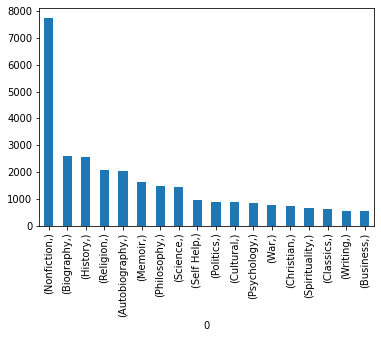

In [107]:
pd.DataFrame(l).value_counts()[pd.DataFrame(l).value_counts()>500].plot.bar()

Parmi non fiction on regroupe : 
 - Biography + Autobiography + Memoir
 - Philosophy + Spirituality + Religion + Christian 
 - History + Politics + War 

In [69]:
[book["genres"] for book in goodread if ]








TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [8]:
all_genres = [ str(genres).split("|") for genres in goodread["genres"]]

In [9]:
all_genres_long =pd.DataFrame([genre for book in all_genres for genre in book])

In [10]:
all_genres_long.columns = ("genre",)

Plotting the main genres we see in all tags

<AxesSubplot:xlabel='genre'>

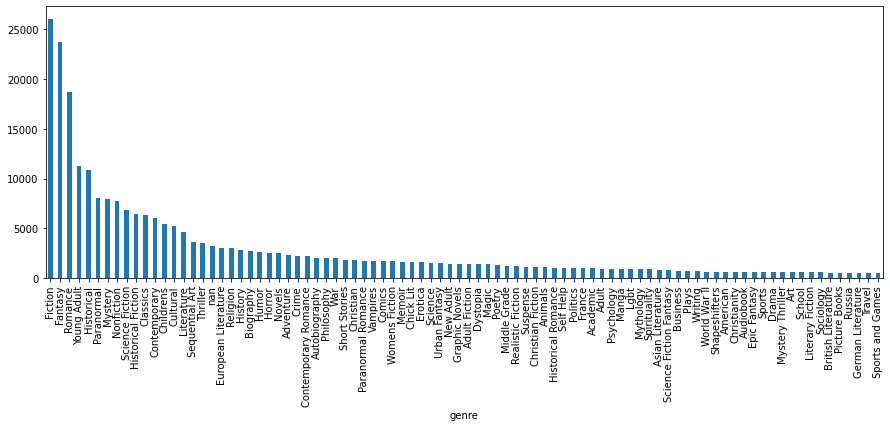

In [13]:
all_genres_long.value_counts("genre")[all_genres_long.value_counts("genre")>500 ].plot.bar(figsize=(15,5))

Doing the same analysis for the first, second and thrid tag

In [15]:
genre_tags = pd.DataFrame(all_genres).iloc[:,0:3]
genre_tags.columns = ("first","second","third")

<AxesSubplot:xlabel='third'>

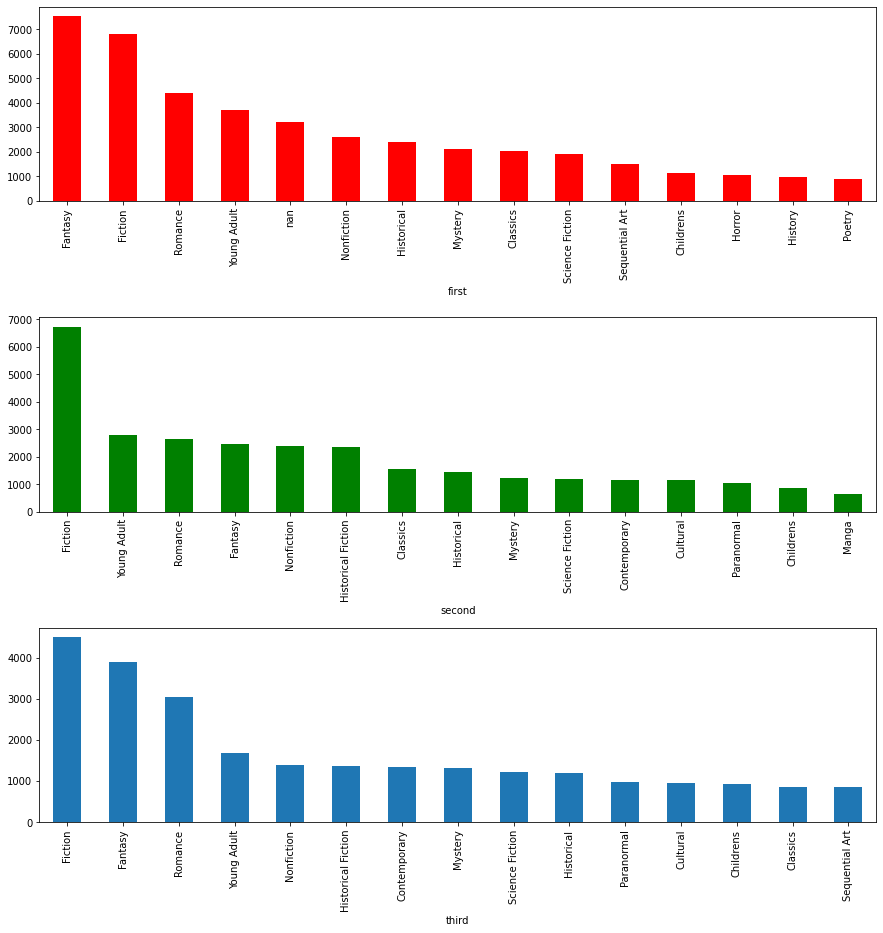

In [16]:
fig,axes  = plt.subplots(nrows = 3 , ncols =1, figsize=(15,15))
fig.subplots_adjust(hspace=0.6)
genre_tags.value_counts("first")[:15].plot.bar(ax=axes[0],color="red")
genre_tags.value_counts("second")[:15].plot.bar(ax=axes[1],color="green")
genre_tags.value_counts("third")[:15].plot.bar(ax=axes[2])

Because there is a lot of overlapping between genres, mont books having multiple tags, we will take on the first tag that is not in  the following categories : 
- Fiction
- Nonfiction
- nan 

In [47]:
genres = pd.DataFrame([next((genre for genre in book if genre not in ["Fiction","nan","Nonfiction"] ),None) for book in all_genres],columns =("genre",))

In [ ]:
glist = ['Fantasy','Romance', 'Young Adult', 'Historical', 'Classics', 'Mystery', 'Science Fiction', 'Sequential Art', 'Cultural', 'History', 'Childrens', 'Horror', 'Poetry', 'Thriller', 'Philosophy', 'Biography', 'Short Stories', 'Novels', 'Religion', 'European Literature', 'Paranormal', 'Christian Fiction', 'Contemporary', 'Womens Fiction', 'Humor', 'Autobiography']

In [144]:
glist = ['Fantasy','Romance', 'Young Adult', 'Historical', 'Mystery', 'Science Fiction', 'Sequential Art', 'History', 'Childrens', 'Horror', 'Poetry', 'War','Politics','Christian','Spirituality','Religion','Philosophy','Memoir','Autobiography','Biography']
genres = pd.DataFrame([next((genre for genre in book if genre in glist),None) for book in all_genres],columns =("genre",))

In [143]:
genres["genre"].isna().sum()

10727

Variant with 3 genres

In [18]:
a = [(genre for genre in book if genre not in ["Fiction","nan","Nonfiction",None])for book in all_genres]
with3cat=[]
for book in a:
    with3cat.append([next(book,None),next(book,None),next(book,None)])
w3cdf = pd.DataFrame(with3cat,columns=("First","Second","Third"))    

In [145]:
final_genres = goodread.drop(goodread.loc[:,"book_desc":"book_review_count"].columns, axis=1).drop("image_url",axis=1)

In [146]:
final_genres["main_genre"] = genres
final_genres["second_genre"] = w3cdf["Second"]
final_genres["third_genre"] = w3cdf["Third"]
final_genres["img"] = final_genres.index.astype('str')+".jpg"

In [148]:
tags = pd.DataFrame(genres.value_counts("genre"), columns =("count",))

In [149]:
tags[tags["count"]>100]

,count
genre,
Fantasy,8732
Romance,6530
Young Adult,4543
Historical,4533
Mystery,3510
Science Fiction,2607
History,1726
Childrens,1687
Sequential Art,1587


<AxesSubplot:xlabel='genre'>

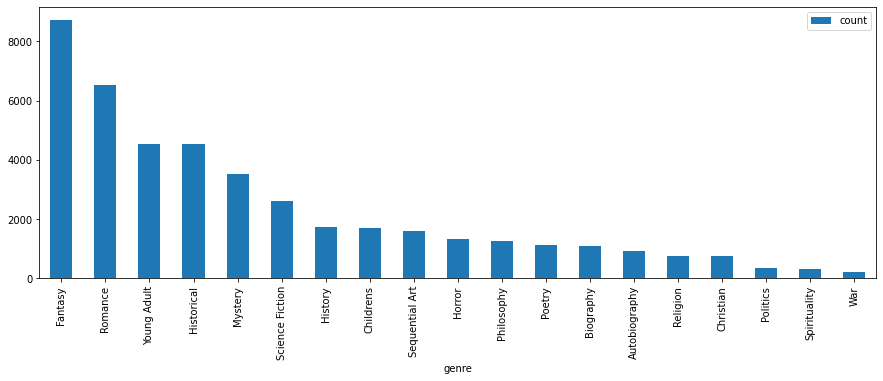

In [150]:
tags[tags["count"]>1].plot.bar(figsize=(15,5))

In [151]:
selected_categories = list(tags[tags["count"]>50].index)

In [154]:
selected_categories

['Fantasy',
 'Romance',
 'Young Adult',
 'Historical',
 'Mystery',
 'Science Fiction',
 'History',
 'Childrens',
 'Sequential Art',
 'Horror',
 'Philosophy',
 'Poetry',
 'Biography',
 'Autobiography',
 'Religion',
 'Christian',
 'Politics',
 'Spirituality',
 'War']

Taking now the first 13 categories

In [155]:
selected_categories = list(tags.index)

In [156]:
selected_categories

['Fantasy',
 'Romance',
 'Young Adult',
 'Historical',
 'Mystery',
 'Science Fiction',
 'History',
 'Childrens',
 'Sequential Art',
 'Horror',
 'Philosophy',
 'Poetry',
 'Biography',
 'Autobiography',
 'Religion',
 'Christian',
 'Politics',
 'Spirituality',
 'War']

In [157]:
def return_label(mg):
    
    if mg in selected_categories:
        val=mg
        if mg in ("Autobiography",'Biography','Memoir') : val = "Biography"
        if mg in ("Spirituality",'Christian','Religion','Philosophy') : val = "Religion & Philosophy"
        if mg in ("Politics",'War','History') : val = "Politics & History"
    else:
        val = "Other"
    return val

In [158]:
#final_genres_filtered = final_genres[final_genres.main_genre.isin(selected_categories)]
final_genres_filtered = final_genres
final_genres_filtered["main_label"]=final_genres_filtered["main_genre"].map(return_label)
final_genres_filtered["second_label"]=final_genres_filtered["second_genre"].map(return_label)
final_genres_filtered["third_label"]=final_genres_filtered["third_genre"].map(return_label)


Checking images

In [159]:
def check_image(fn):
    try:
        fobj = open(fn, "rb")
        is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        if not is_jfif: raise NameError('corrupt file')
        file_contents = tf.io.read_file(fn)
        image = tf.image.decode_jpeg(file_contents, channels=3)
    except:
        print("check error",fn)
        raise NameError('corrupt file')

In [ ]:
num_skipped = 0
num_copied = 0 
file_exists = 0
for index,book in final_genres_filtered.iterrows():
    genre = book["main_label"]
    fpath = str(orig_path) +"\\"+book["img"]
    target= str(destin_path)+"\\"+genre+"\\"+book["img"]
    if not os.path.exists(str(destin_path)+"\\"+genre): 
        os.mkdir(str(destin_path)+"\\"+genre)
    try:
        if os.path.isfile(target):
            file_exists+=1
        else:
            check_image(fpath)
    except:
        print("error, the following image was not copied",fpath)
        num_skipped+=1
    else:
        try:
            if not os.path.isfile(target):
                shutil.copy(fpath,target)
                num_copied +=1

        except IOError as e:
            print("Unable to copy file. %s" % e)
        except:
            print("Unexpected error:", sys.exc_info())
print("We skipped %d corrupt images" % num_skipped)
print("There were already %d files there" %file_exists)
print("We copied %d files" %num_copied)

In [101]:
%store final_genres_filtered

Stored 'final_genres_filtered' (DataFrame)


In [169]:
final_genres_filtered = final_genres_filtered[final_genres_filtered.main_label != "Other"]

<AxesSubplot:xlabel='main_label'>

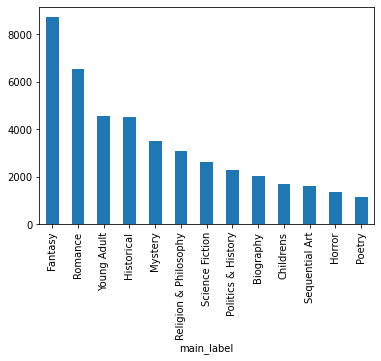

In [170]:
final_genres_filtered.value_counts("main_label").plot.bar()

In [171]:
final_genres_filtered.to_csv("final_genres.csv")

<AxesSubplot:xlabel='second_label'>

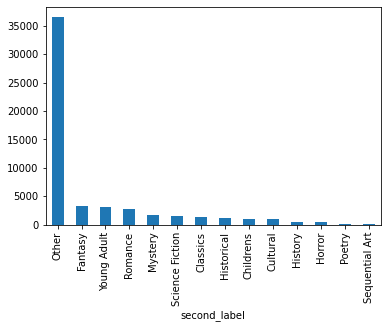

In [24]:
final_genres_filtered.value_counts("second_label").plot.bar()

<AxesSubplot:xlabel='third_label'>

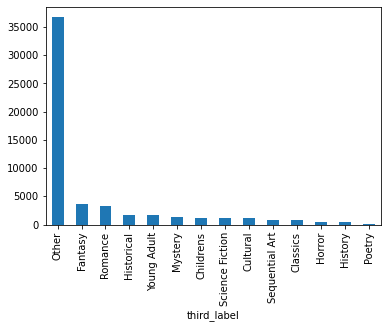

In [25]:
final_genres_filtered.value_counts("third_label").plot.bar()